<h1>CNN - Processing</h1>

<h5>Importing Packages</h5>

In [1]:
useKerasTfV1=False
useKerasTfV2=False
useTfV2=True

In [ ]:
try:
    from google.colab import drive
    drive.mount('/drive', force_remount=False)
    %run "/drive/My Drive/Colab Notebooks/Notebooks/Deep Learning - Processing.ipynb"
except:
    %run "/Google Drive/Colab Notebooks/Notebooks/Deep Learning - Processing.ipynb"

<h5>Models</h5>

In [3]:
def model(name):

    def modelBuilder(n_convolutional, n_features, n_outputs):
        model = Sequential()
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(n_convolutional, n_features)))
        model.add(BatchNormalization())
        model.add(SpatialDropout1D(0.15))
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
        model.add(BatchNormalization())
        model.add(SpatialDropout1D(0.15))
        model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
        model.add(GlobalAvgPool1D())
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(n_outputs, activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
        return model, name

    return modelBuilder

In [4]:
def parameters(input_shape, output_shape):

    return {
        "n_convolutional": input_shape[1], 
        "n_features": input_shape[2], 
        "n_outputs": output_shape[1]
    }

<h5>Parameters</h5>

In [5]:
datasets = getDataSets()

In [6]:
sides = ['left', 'right']
mode_label = True
moving_window = False
compositeAccFeatures = False
frequencyDomain=False

if compositeAccFeatures:
    input_features = 11
else:
    input_features = 7

if frequencyDomain:
    frequencies = int((fft_window / 2) + 1)
    input_features = frequencies * input_features

In [7]:
# (batches, window size, features)
input_shapes = [
    ((None, 100, input_features), 100), 
    ((None, 200, input_features), 200), 
    ((None, 300, input_features), 300)
]

output_shape = (None, 3)

<h5>Training</h5>

In [ ]:
getLoadBar()

In [ ]:
run(
    model("CNN " + ("Frequency" if frequencyDomain else "Time") + " Domain " + str(input_features) + " Features"), 
    addCompositeAccFeatures=compositeAccFeatures,
    frequencyDomain=frequencyDomain
)

<h5>Confusion Matrix - Best Model</h5>

In [99]:
files = [
    'experiment-1-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.94669-val-acc-0.94776.hdf5',
    'experiment-2-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.94398-val-acc-0.92171.hdf5',
    'experiment-3-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.97008-val-acc-0.92170.hdf5'
]

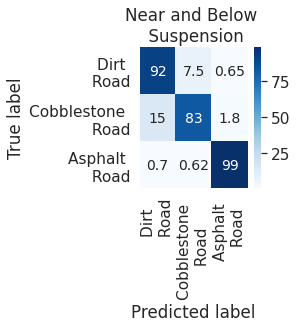

In [100]:
confusionMatrix(files, "Near and Below \n Suspension", model("CNN Time Domain 7 Features"), (None, 300, 7), (None, 3), experiment_by_fields[0])

In [101]:
files = [
    'experiment-1-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.88457-val-acc-0.94108.hdf5',
    'experiment-2-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.92893-val-acc-0.90141.hdf5',
    'experiment-3-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.95449-val-acc-0.91803.hdf5'
]

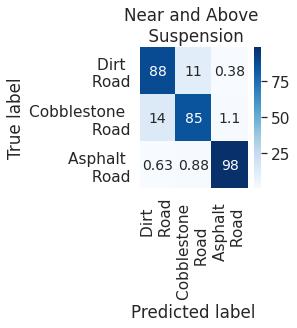

In [102]:
confusionMatrix(files, "Near and Above \n Suspension", model("CNN Time Domain 7 Features"), (None, 300, 7), (None, 3), experiment_by_fields[1])

In [103]:
files = [
    'experiment-1-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.93164-val-acc-0.95247.hdf5',
    'experiment-2-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.94837-val-acc-0.89934.hdf5',
    'experiment-3-window-300-scaler-min-max-scaler-(-1, 1)-train-acc-0.97493-val-acc-0.93964.hdf5'
]

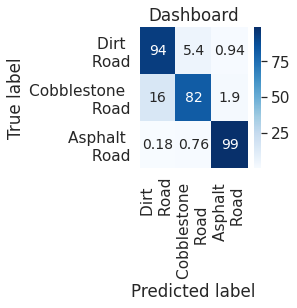

In [104]:
confusionMatrix(files, "Dashboard", model("CNN Time Domain 7 Features"), (None, 300, 7), (None, 3), experiment_by_fields[2])

In [84]:
# Plot best model CNN 7 features window 300 time domain
def confusionMatrix(files, title, model_fn, input_shape, output_shape, experiment_by_fields):

    placement = experiment_by_fields[0] 
    fields = experiment_by_fields[1] 

    matrix = []
    subsets = getSubSets(datasets.copy(), fields, surface_type_labels)
    normalized_sets = getNormalizedDataMinMax(subsets, (-1,1))
    reshaped_sets = getReshapedData(normalized_sets, input_shape, moving_window, mode_label)

    for experiment_number in range(0,3):

        sets_train = experiment_by_dataset[experiment_number]['train']
        sets_test = experiment_by_dataset[experiment_number]['test']

        input_train, input_test, output_train, output_test = getTrainTestSets(reshaped_sets.copy(), sets_train, sets_test, sides)

        model_args = parameters(input_shape, output_shape)
        model, model_name = model_fn(**model_args)
        loadWeights(model, os.path.join(experiments_folder, model_name, placement, "Experiment " + str(experiment_number + 1), files[experiment_number]))
        predictions = predictModel(model, input_test)
        matrix.append(confusion_matrix(output_test.argmax(axis=1), predictions.argmax(axis=1), normalize="true"))

    values = ((matrix[0] + matrix[1] + matrix[2])/3)*100
    con_mat_df = pd.DataFrame(values, index=surface_type_labels_plot, columns=surface_type_labels_plot)
    figure = plt.figure(figsize=(4,4))
    sns.set(font_scale=1.4)
    sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues, annot_kws={"size": 14})
    plt.tight_layout()
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    figure.savefig('confusion_matrix.png', bbox_inches="tight")